# **Name:** Subhadeep Chaudhuri | **Roll no.** : 19i190010

## **Question:**
Implement and compare different algorithms for sampling the arms of a
stochastic multi-armed bandit. Each arm provides i.i.d. rewards from a Bernoulli distribution with given means. The objective is to minimise the regret. The algorithms you will implement are epsilon-greedy exploration, UCB, KL-UCB, Thompson Sampling.

For epsilon greedy, you can choose $\epsilon = 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7$

In [1]:
###########################################
## Importing the necessary packages
###########################################
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import scipy.stats as ss
import copy
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [2]:
###############################
## Different arms
###############################
arm1 = 0
arm2 = 1
arm3 = 2
arm4 = 3
arm5 = 4

###############################
## Different algorithm types
###############################
EPS = 6
UCB = 7
KL_UCB = 8
TS = 9

In [3]:
#####################################################################
## Function to generate reward for each arm depending on arm number
#####################################################################
def reward_gen(arm):
    if arm == arm1:
        return np.random.binomial(1, 0.4)
    elif arm == arm2:
        return np.random.binomial(1, 0.3)
    elif arm == arm3:
        return np.random.binomial(1, 0.5)
    elif arm == arm4:
        return np.random.binomial(1, 0.2)
    elif arm == arm5:
        return np.random.binomial(1, 0.1) 
    else:
        raise ValueError("Incorrect input for Arm number. Should be of form 'arm__' with __ = 1(1)5" )

### **Algorithm 1**: $\epsilon$-greedy algorithm

In [4]:
##########################################################################################
## Function to define the epsilon-greedy algorithm
## Input: No of arms K, horizon, epsilon value, array containing all the given arm means
##########################################################################################
def eps_greedy(K, horizon, arm_means, epsilon):
    reward_array = np.zeros(K)
    count_array = np.zeros(K)
    regret_array_final = []
    total_expected_reward = 0
    for i in range(K):
        reward_array[i] += reward_gen(i)
        count_array[i] += 1
        best_arm_reward = max(arm_means)*(i+1)
        total_expected_reward += arm_means[i]
        regret = best_arm_reward - total_expected_reward
        regret_array_final.append(regret)
        # print(f"Round: {i+1}, chosen arm = {i} Best: {best_arm_reward}  exp: {total_expected_reward} Regret: {regret}")
    
    round = K+1
    while round <= horizon:
        unif = np.random.uniform()
        if unif <= epsilon:
            chosen_arm = np.random.choice(K)
            reward_array[chosen_arm] += reward_gen(chosen_arm)
            count_array[chosen_arm] += 1
        else:
            chosen_arm = np.argmax(np.divide(reward_array, count_array))
            reward_array[chosen_arm] += reward_gen(chosen_arm)
            count_array[chosen_arm] += 1
        
        best_arm_reward = max(arm_means)*round 
        total_expected_reward += arm_means[chosen_arm]
        
        regret = best_arm_reward - total_expected_reward
        regret_array_final.append(regret)
        # print(f"Round: {round}, chosen arm = {chosen_arm} Best: {best_arm_reward}  exp: {total_expected_reward} Regret: {regret}")
        round += 1

    return regret_array_final, count_array

### **Algorithm 2**: UCB algorithm

In [5]:
###############################################################################
## Function to define the UCB algorithm
## Input: No of arms K, horizon, array containing all the given arm means
###############################################################################
def UCB(K, horizon, arm_means):
    reward_array = np.zeros(K)
    count_array = np.zeros(K)
    regret_array_final = []
    total_expected_reward = 0
    for i in range(K):
        reward_array[i] += reward_gen(i)
        count_array[i] += 1
        best_arm_reward = max(arm_means)*(i+1)
        total_expected_reward += arm_means[i]
        regret = best_arm_reward - total_expected_reward
        regret_array_final.append(regret)
    
    round = K+1
    while round <= horizon:
        mu_hat = np.divide(reward_array, count_array)
        ucb_bounds = mu_hat + np.sqrt(np.divide(2*np.log(round), count_array))
        chosen_arm = np.argmax(ucb_bounds)
        
        reward_array[chosen_arm] += reward_gen(chosen_arm)
        count_array[chosen_arm] += 1
        best_arm_reward = max(arm_means)*round 
        total_expected_reward += arm_means[chosen_arm]
        
        regret = best_arm_reward - total_expected_reward
        regret_array_final.append(regret)

        round += 1

    return regret_array_final, count_array

### **Algorithm 3**: KL-UCB algorithm

In [6]:
###############################################
## Function to calculate the relative entropy
## Input: p, q
###############################################
def rel_entropy(p, q):
    if (p == 0) and  (q > 0) and (q < 1):
        return np.log(1/(1-q))
    elif (p == 1) and  (q > 0) and (q < 1):
        return np.log(1/q)
    elif (q == 0) and (p == 0):
        return 0
    elif (q == 0) and (p != 0):
        return np.inf
    elif (q == 1) and (p == 1):
        return 0
    elif (q == 1) and (p != 1):
        return np.inf        
    else:
        return p*np.log(p/q) + (1-p)*np.log((1-p)/(1-q))

####################################################################
## Function to calcalate the upper confidence bound in KL-UCB algo
####################################################################
def kl_ucb_bound(t, count, mu):
    c = 3
    delta = 1e-2
    q_max = []
    rhs = np.log(t) + c*np.log(np.log(t))
    lhs = np.zeros(len(count))
    for i in range(len(count)):
        q = mu[i]
        lhs[i] = count[i]*rel_entropy(mu[i], q)
        while (lhs[i] <= rhs) and (q <= 1):
            q = q + delta
            lhs[i] = count[i]*rel_entropy(mu[i], q)
        q_max.append(q)
    return q_max
    

#############################################################################
## Function to define the KL-UCB algorithm
## Input: No of arms K, horizon, array containing all the given arm means
#############################################################################
def KL_UCB_algo(K, horizon, arm_means):
    reward_array = np.zeros(K)
    count_array = np.zeros(K)
    regret_array_final = []
    total_expected_reward = 0
    for i in range(K):
        reward_array[i] += reward_gen(i)
        count_array[i] += 1
        best_arm_reward = max(arm_means)*(i+1)
        total_expected_reward += arm_means[i]
        regret = best_arm_reward - total_expected_reward
        regret_array_final.append(regret)
    
    round = K+1
    while round <= horizon:
        mu_hat = np.divide(reward_array, count_array)
        bounds = kl_ucb_bound(round, count_array, mu_hat)
        chosen_arm = np.argmax(bounds)
        
        reward_array[chosen_arm] += reward_gen(chosen_arm)
        count_array[chosen_arm] += 1
        best_arm_reward = max(arm_means)*round 
        total_expected_reward += arm_means[chosen_arm]
        
        regret = best_arm_reward - total_expected_reward
        regret_array_final.append(regret)

        round += 1

    return regret_array_final, count_array

### **Algorithm 4**: Thompson Sampling algorithm

In [7]:
##########################################################################################
## Function to define the Thompson Sampling algorithm
## Input: No of arms K, horizon, array containing all the given arm means
##########################################################################################
def thompson(K, horizon, arm_means):
    S = np.zeros(K)
    F = np.zeros(K)
    theta = np.zeros(K)
    count_array = np.zeros(K)
    regret_array_final = []
    total_expected_reward = 0
    round = 1
    while round <= horizon:
        for i in range(K):
            theta[i] = np.random.beta(S[i] + 1, F[i] + 1)
        chosen_arm = np.argmax(theta)
        reward = reward_gen(chosen_arm)
        count_array[chosen_arm] += 1
        if reward == 1:
            S[chosen_arm] += 1
        else:
            F[chosen_arm] += 1
        best_arm_reward = max(arm_means)*round 
        total_expected_reward += arm_means[chosen_arm]
        
        regret = best_arm_reward - total_expected_reward
        regret_array_final.append(regret)

        round += 1

    return regret_array_final, count_array

### **Defining a function that will average out the results over multiple runs**
- Input: 
> - Number of runs: runs
> - Algorithm type: algo_type
> - Extra arguments depending on the chosen algorithm type: *args 
- Output: 
> - Average regret over all the runs in each round
> - Deviation over the multiple runs (will be used to plot the error bars or CI)
> - Average number of pulls of each arm 

In [8]:
####################################################################################
## Method to call the different algorithms over multiple runs
## Algorithm choices: epsilon-greedy exploration, UCB, KL-UCB, Thompson Sampling
####################################################################################

def algo_over_runs(runs, algo_type, K, horizon, arm_means, *args):

    ## Checking the validity of the arguments required in eps-greedy algorithm
    #################################################################################
    if algo_type == EPS:
        if args is None:
            err_msg = 'Arguments are missing. Check again!'
            raise ValueError(err_msg)
        else:
            epsilon = args[0]


    ## Storing the regret obtained for each run in an array and then averaging out
    ###############################################################################
    regret_array = [_ for i in range(runs)]
    count_array = [_ for i in range(runs)]
    regret_error = []
    for i in range(runs):
        if algo_type == EPS:
            regret_array[i], count_array[i] = eps_greedy(K, horizon, arm_means, epsilon)      
        elif algo_type == UCB:
            regret_array[i], count_array[i] = UCB(K, horizon, arm_means) 
        elif algo_type == KL_UCB:
            regret_array[i], count_array[i] = KL_UCB_algo(K, horizon, arm_means)
        elif algo_type == TS:
            regret_array[i], count_array[i] = thompson(K, horizon, arm_means)
        else:
            raise ValueError('Invalid algorithm type. Check again!')             

    regret_array, count_array = np.array(regret_array), np.array(count_array)
    regret_error = np.array(ss.t.ppf(0.95, df = runs -1)*ss.sem(regret_array, axis = 0))

    return np.mean(regret_array, axis = 0), regret_error, np.mean(count_array, axis = 0)

### **Running the $\epsilon$-greedy algorithm for the different choices of $\epsilon$**
We run the epsilon-greedy algorithm for all the given choices of $\epsilon$ i.e. $\{0.05, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.7\}$.
- The average number of pulls of each arm over multiple runs is displayed
- The regret plots are displayed for each choice of $\epsilon$

**Comments:** Intuitionally, we know that the best result would be obtained for the smallest choice of $\epsilon$. The results are verified through the regret plot and we get the smallest regret for $\epsilon = 0.05$

For epsilon = 0.05:
Average counts of each arm (L-R: arm1 - arm5): [ 1701.96  1005.78 95295.1    999.12   998.04]
Average regret after algorithm runs till horizon: 1070.3039999999762
-------------------------------------------------------------------------------------------
For epsilon = 0.1:
Average counts of each arm (L-R: arm1 - arm5): [ 2136.92  2034.72 91820.68  2003.64  2004.04]
Average regret after algorithm runs till horizon: 2023.3440000000048
-------------------------------------------------------------------------------------------
For epsilon = 0.2:
Average counts of each arm (L-R: arm1 - arm5): [ 4172.28  4040.1  83792.08  4004.22  3991.32]
Average regret after algorithm runs till horizon: 4023.0419999999676
-------------------------------------------------------------------------------------------
For epsilon = 0.3:
Average counts of each arm (L-R: arm1 - arm5): [ 6106.34  5998.84 75880.08  6021.88  5992.86]
Average regret after algorithm runs till horizon: 6014.110000000

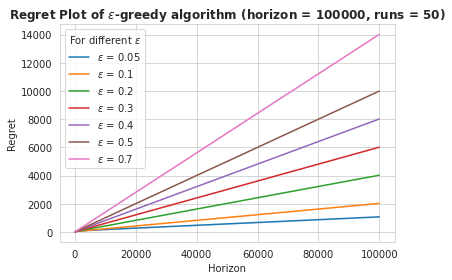

In [9]:
####################################
## Parameters of the algorithm
####################################
horizon = 100000
eps = [0.05, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.7]
K = 5
arm_means = [0.4, 0.3, 0.5, 0.2, 0.1]
runs = 50


##########################################################
## Running the algorithm for all the choices of epsilon
##########################################################
for i in range(len(eps)):
    mean_regret_array_EPS, regret_error_EPS, avg_count = algo_over_runs(runs, EPS, K, horizon, arm_means, eps[i])
    plt.plot(mean_regret_array_EPS, label = f"$\epsilon$ = {eps[i]}")
    plt.fill_between(np.arange(horizon), mean_regret_array_EPS - regret_error_EPS, mean_regret_array_EPS + regret_error_EPS, alpha=0.3)
    plt.xlabel("Horizon")
    plt.ylabel("Regret")

    print(f"For epsilon = {eps[i]}:")
    print(f"Average counts of each arm (L-R: arm1 - arm5): {avg_count}")
    print(f"Average regret after algorithm runs till horizon: {mean_regret_array_EPS[-1]}")
    print("-------------------------------------------------------------------------------------------")

plt.title(f"Regret Plot of $\epsilon$-greedy algorithm (horizon = {horizon}, runs = {runs})", fontweight = 'bold')
plt.legend(title = "For different $\epsilon$")
plt.show()


In [ ]:
###########################################
## Parameters of the different algorithms
###########################################
horizon = 100000
epsilon = 0.05
arm_means = [0.4, 0.3, 0.5, 0.2, 0.1]
K = 5
runs = 50
algo_types = [EPS, UCB, KL_UCB, TS]
algo_names = ["Eps-greedy", "UCB", "KL-UCB", "Thompson Sampling"]

### **Running the different algorithms for the specified parameters**
We run the epsilon-greedy algorithm for $\epsilon = 0.05$ since it gives the best result. The other algorithms are run for the above specified parameters
- The average number of pulls of each arm over multiple runs is displayed
- The regret plots are displayed over the horizon

**Comments:** 
- The regret should be of the following order: **Thompson Sampling < KL-UCB < UCB < $\epsilon$-greedy algorithm**
- The regret plots obtained show the expected results and thus verify the validity of the algorithms. 

For algo type = Eps-greedy:
Average counts of each arm (L-R: arm1 - arm5): [ 1734.68  1019.7  95241.18  1006.24   998.2 ]
Average regret after algorithm runs till horizon: 1078.5599999999895
-------------------------------------------------------------------------------------------
For algo type = UCB:
Average counts of each arm (L-R: arm1 - arm5): [ 1739.28   486.06 97413.9    230.46   130.3 ]
Average regret after algorithm runs till horizon: 392.3979999995687
-------------------------------------------------------------------------------------------
For algo type = KL-UCB:
Average counts of each arm (L-R: arm1 - arm5): [7.966000e+02 2.064000e+02 9.885402e+04 9.460000e+01 4.838000e+01]
Average regret after algorithm runs till horizon: 168.671999999798
-------------------------------------------------------------------------------------------
For algo type = Thompson Sampling:
Average counts of each arm (L-R: arm1 - arm5): [3.216800e+02 9.050000e+01 9.952558e+04 3.862000e+01 2.362000e+

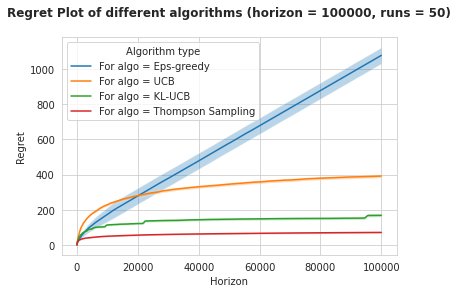

In [ ]:
##########################################################
## Running all the algorithms for the specified parameters
##########################################################

for j in range(len(algo_types)):
    mean_regret_array, regret_error, avg_count = algo_over_runs(runs, algo_types[j], K, horizon, arm_means, epsilon)
    plt.plot(mean_regret_array, label = f"For algo = {algo_names[j]}")
    plt.fill_between(np.arange(horizon), mean_regret_array - regret_error, mean_regret_array + regret_error, alpha=0.3)
    plt.xlabel("Horizon")
    plt.ylabel("Regret")

    print(f"For algo type = {algo_names[j]}:")
    print(f"Average counts of each arm (L-R: arm1 - arm5): {avg_count}")
    print(f"Average regret after algorithm runs till horizon: {mean_regret_array[-1]}")
    print("-------------------------------------------------------------------------------------------")
print()

plt.title(f"Regret Plot of different algorithms (horizon = {horizon}, runs = {runs})\n", fontweight = 'bold')
plt.legend(title = "Algorithm type")
plt.show()